# Function 3 - Drug Discovery Problem
- You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero.

In [2]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_3/initial_inputs.npy")
f1_out = np.load("./../function_3/initial_outputs.npy")
f1_out

file2_inp = np.load("./../../initial_data2/function_3/initial_inputs.npy")
file2_out = np.load("./../../initial_data2/function_3/initial_outputs.npy")

f1_inp = np.concatenate((f1_inp, file2_inp))
f1_out = np.concatenate((f1_out, file2_out))

q1_inp = [0.586471, 0.735744, 0.044887]
q1_out = [-0.04562659048163968]

q2_inp = [0.162977, 0.418159, 0.571131]
q2_out = [-0.04184082807932257]        

q3_inp = [0.999745, 0.812448, 0.151386]
q3_out = [-0.1253984755037782]


q4_inp = [0.968584, 0.55088 , 0.335599]
q4_out = [-0.04474717158628833]

q5_inp = [0.435129, 0.492539, 0.66649 ]
q5_out = [-0.10448271348295962]

q6_inp = [0.999999, 0.391643, 0.999999]
q6_out = [-0.450707336809612]


q7_inp = [4.96807e-01, 1.00845e-01, 2.00000e-06]
q7_out = [-0.1544068560195687]

q8_inp = [0.37029 , 0.183106, 0.440557]
q8_out = [-0.052370969743849666]




q9_inp = [0.515077, 0.193407, 0.38536 ]
q9_out = [-0.03795192190568227]

q10_inp = [0.56653 , 0.329309, 0.523493]
q10_out = [-0.02492535762079552]


q11_inp = [0.576528, 0.319323, 0.493549]
q11_out = [-0.02181244366857043]

q12_inp = [0.576528, 0.319323, 0.453549]
q12_out = [-0.013166584166154353]


q13_inp = [0.578528, 0.319323, 0.433549]
q13_out = [-0.012108984367773658]

f1_inp = np.vstack((f1_inp, q1_inp, q2_inp, q3_inp, q4_inp, q5_inp,q6_inp,q7_inp,q8_inp,q9_inp,q10_inp,q11_inp,q12_inp,q13_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out, q4_out, q5_out,q6_out,q7_out,q8_out,q9_out,q10_out,q11_out,q12_out,q13_out])
f1_inp, f1_out
max(f1_out), np.mean(f1_out)

len(f1_inp), len(f1_out)

max(f1_out)  
x_final = f1_inp
y_final = f1_out

np.float64(-0.012108984367773658)

In [5]:
import numpy as np

# Get indices of top 3 outputs (higher = better)
top_indices = np.argsort(y_final)[-6:][::-1]

# Get the top 3 output values
top_outputs = y_final[top_indices]

# Get corresponding inputs
top_inputs = x_final[top_indices]
top_inputs,top_outputs
# 0.586528-0.319323-0.433549 
# 0.578528  , 0.319323  , 0.443549 

(array([[0.576528  , 0.319323  , 0.453549  ],
        [0.576528  , 0.319323  , 0.493549  ],
        [0.56653   , 0.329309  , 0.523493  ],
        [0.57579775, 0.32285284, 0.53417744],
        [0.65099632, 0.42417272, 0.52674437],
        [0.82217052, 0.46650685, 0.54929183]]),
 array([-0.01316658, -0.02181244, -0.02492536, -0.02514614, -0.03103939,
        -0.03435924]))

In [6]:
max(f1_out) , min(f1_out), np.mean(f1_out)

(np.float64(-0.02492535762079552),
 np.float64(-0.450707336809612),
 np.float64(-0.0996926553767227))

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.
- Prior Knowledge: One of the features might not impact the outcome, consider to remove it


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [8]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

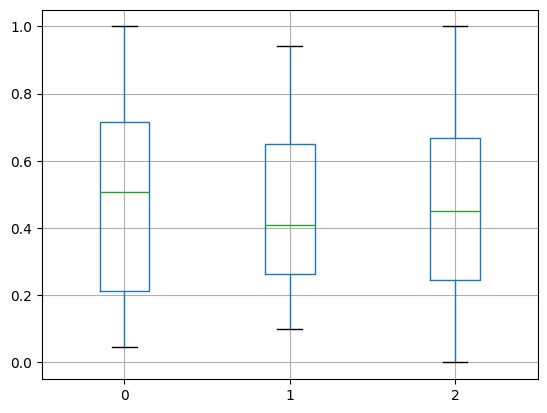

In [9]:
## Checking for outliers

pd_inp.boxplot() # OUTLIER DEDECTED ON THE 3RD FEATURE OF INPUTS
plt.show()

<Axes: >

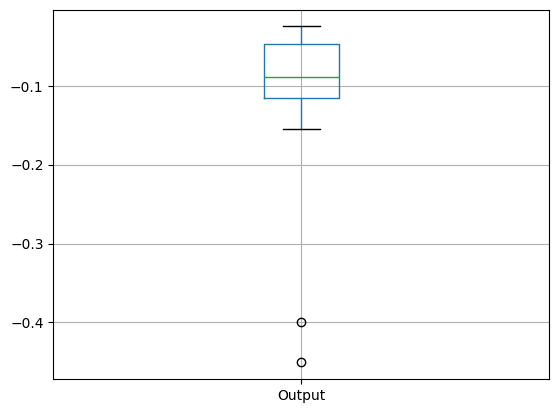

In [10]:
pd_out.boxplot() # OUTLIER DEDECTED

## Distribution 

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

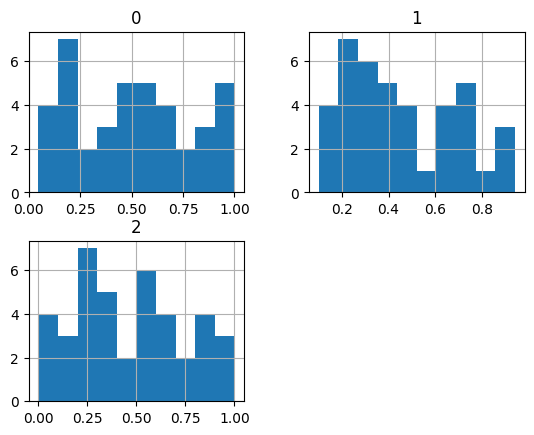

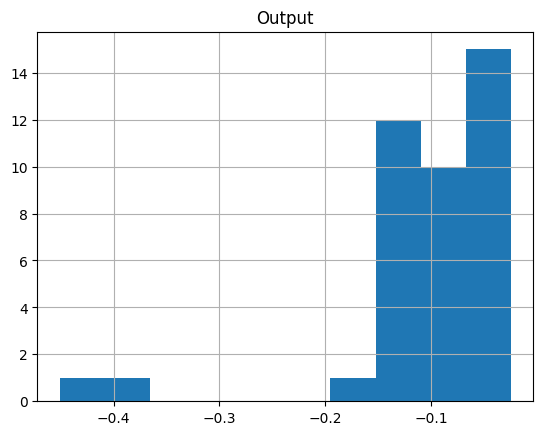

In [11]:
pd_inp.hist(), pd_out.hist()

In [12]:
# I doubt that the distribution is impacted from the outliers. CONSIDERING TO TRANFORM/OUTLIERS 

In [13]:
skew(f1_inp),skew(f1_out)


np.var(f1_inp),np.var(f1_out)

(np.float64(0.07314043341017655), np.float64(0.0069023209418594186))

# Input/Output Relationship Analysis 

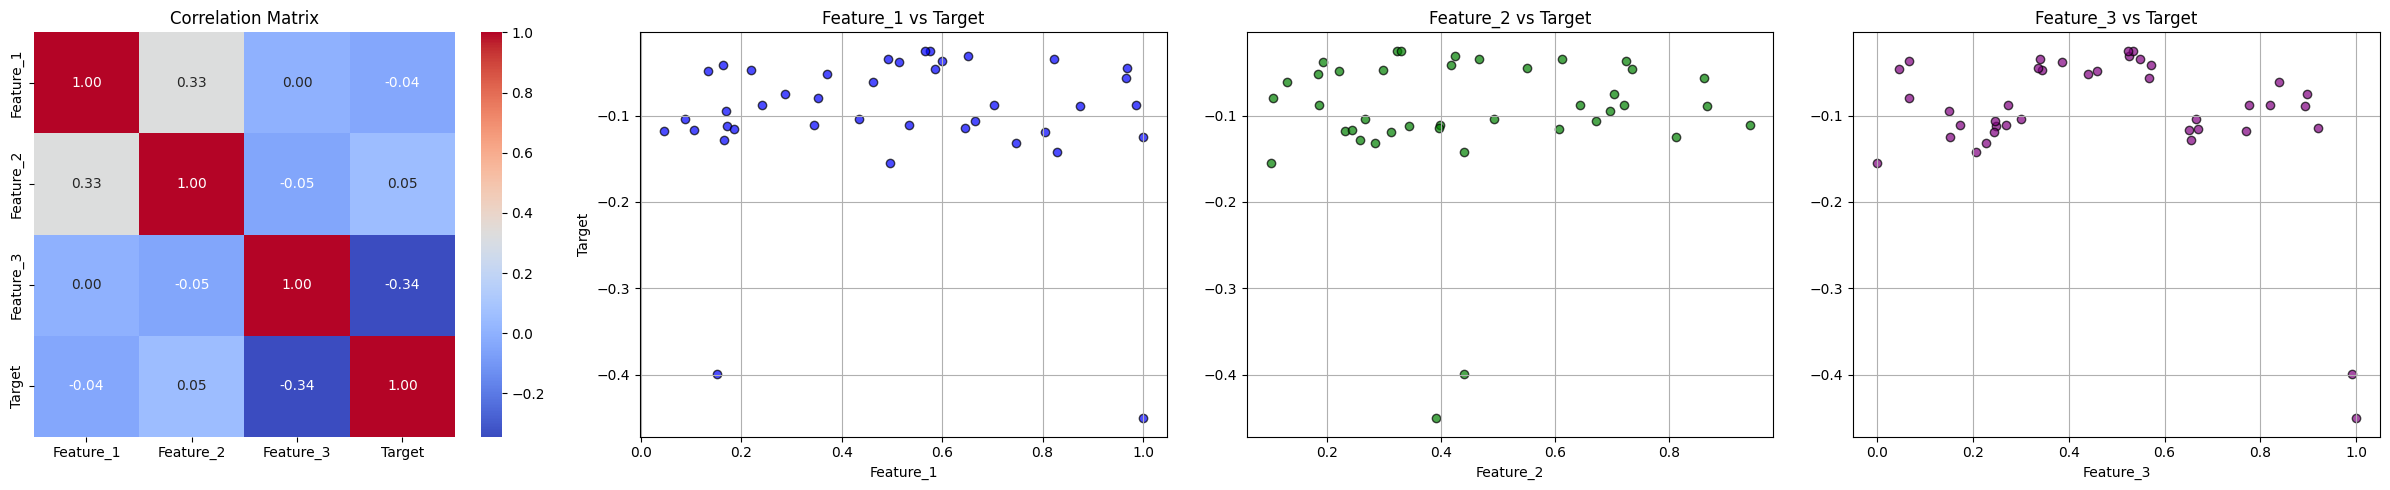

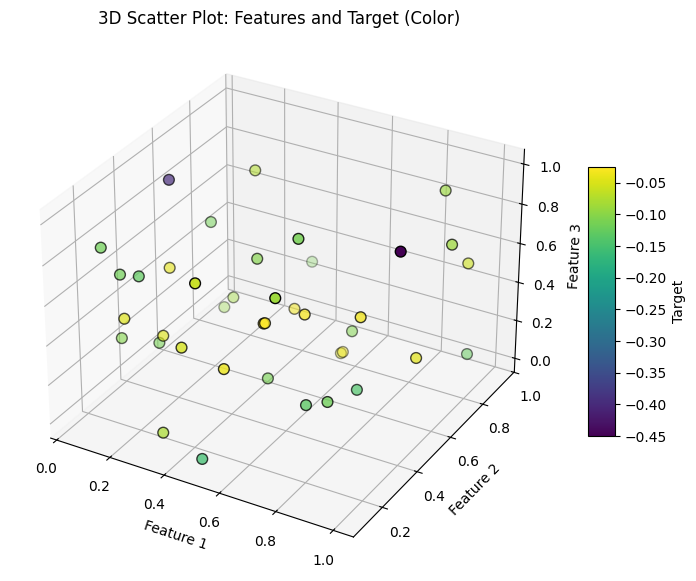

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Ensure f1_out is 1D
f1_out = f1_out.ravel()

# Create a figure for the inline plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# **1. Correlation Matrix**
# Convert f1_inp and f1_out to a single NumPy array for correlation
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Plot correlation heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix")

# **2. Scatter Plot: Feature 1 vs Target**
axes[1].scatter(f1_inp[:, 0], f1_out, color="blue", alpha=0.7, edgecolor="k")
axes[1].set_xlabel("Feature_1")
axes[1].set_ylabel("Target")
axes[1].set_title("Feature_1 vs Target")
axes[1].grid(True)

# **3. Scatter Plot: Feature 2 vs Target (if exists)**
if f1_inp.shape[1] > 1:
    axes[2].scatter(f1_inp[:, 1], f1_out, color="green", alpha=0.7, edgecolor="k")
    axes[2].set_xlabel("Feature_2")
    axes[2].set_title("Feature_2 vs Target")
    axes[2].grid(True)
else:
    axes[2].axis("off")
    axes[2].set_title("Feature_2 vs Target (Not Available)")

# **4. Scatter Plot: Feature 3 vs Target (if exists)**
if f1_inp.shape[1] > 2:
    axes[3].scatter(f1_inp[:, 2], f1_out, color="purple", alpha=0.7, edgecolor="k")
    axes[3].set_xlabel("Feature_3")
    axes[3].set_title("Feature_3 vs Target")
    axes[3].grid(True)
else:
    axes[3].axis("off")
    axes[3].set_title("Feature_3 vs Target (Not Available)")

plt.tight_layout()
plt.show()

# **3D Scatter Plot for Three Features**
# Only proceed if there are at least 3 features
if f1_inp.shape[1] >= 3:
    from mpl_toolkits.mplot3d import Axes3D  # import 3D plotting toolkit

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Use the first three features for the 3D scatter plot
    x, y, z = f1_inp[:, 0], f1_inp[:, 1], f1_inp[:, 2]
    sc = ax.scatter(x, y, z, c=f1_out, cmap="viridis", edgecolor="k", s=60)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    plt.title("3D Scatter Plot: Features and Target (Color)")

    cb = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cb.set_label("Target")
    plt.show()
else:
    print("3D scatter plot requires at least 3 features in the input data.")
[0.576528  , 0.319323  , 0.493549

### Conclusion about input/ouput relationship
- Feature 2 has a very small correlation with the target variable, considering to remove it 



# DROPING FEATURE 2 - I will use a high kernel length for feature 2


In [15]:
import numpy as np

# Get indices of top 3 outputs (higher = better)
top_indices = np.argsort(y_final)[-4:][::-1]

# Get the top 3 output values
top_outputs = y_final[top_indices]

# Get corresponding inputs
top_inputs = x_final[top_indices]
top_inputs,top_outputs
# 0.586528-0.319323-0.433549 
# 0.578528  , 0.319323  , 0.443549 

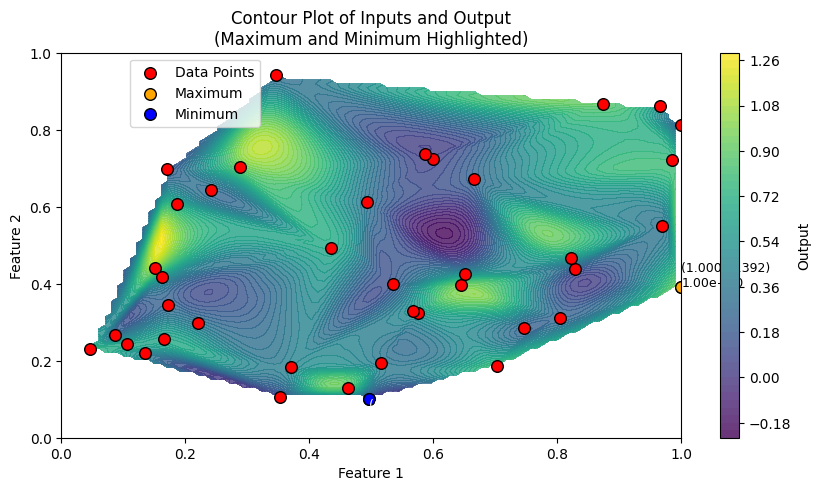

Max: 1.00e+00 at (1.0000, 0.3916)
Min: 2.00e-06 at (0.4968, 0.1008)


In [17]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
plt.legend()
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))

plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")

- From above we could see that Feature 1 was more correlated with output variable, so we might exepect that to grow on the result of acquistion function

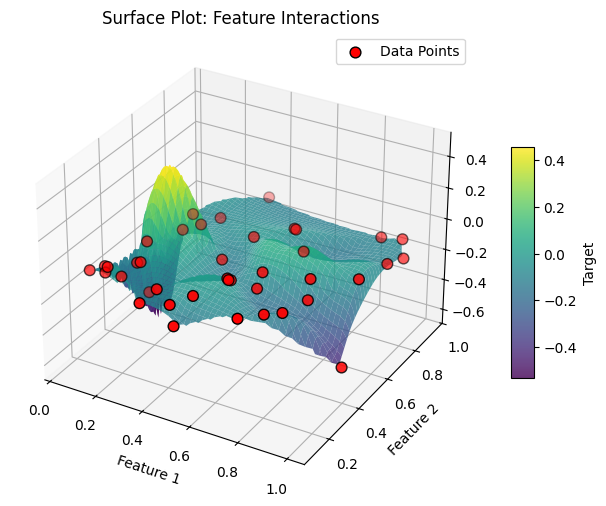

In [18]:
x, y = f1_inp[:, 0], f1_inp[:, 1]
z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
- Test after you have built the surrogate model, if there are future that just add noise and affect predictions 

In [19]:
# Analysing skewnes and variance 




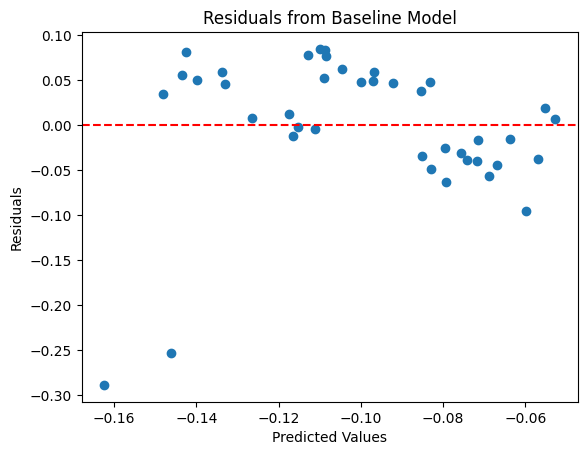

Residual Variance: 0.006
Residual Mean: 0.000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [21]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 0.001
Residual Variance (Noise): 0.006
Residual Skewnes : -1.987
Signal-to-Noise Ratio (SNR): 0.140



### Conclusion
- Weak signal compared to noise
- Residuals show negative skew
- Low SNR calls for model/data improvements

# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [22]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension


amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]

(np.float64(0.08413859714846822),
 array([0.29538667, 0.23253422, 0.28681604]),
 [array([-0.04851006,  0.01679352, -0.0999977 ]),
  array([1.09531801, 1.02541131, 1.0999987 ])])

- Start with the above Amplitude but let the optimizer refine it during training

In [23]:
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
length_scale_init

array([0.29538667, 0.23253422, 0.28681604])

- Start with the above Lenfthscale but let the optimizer refine it during training

In [24]:
# Bounds will always be the bounds of the input variable, IMPORTANT TO CHECK FOR OUTLIERS

In [25]:
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension
extended_min_bounds, extended_max_bounds

(array([-0.04851006,  0.01679352, -0.0999977 ]),
 array([1.09531801, 1.02541131, 1.0999987 ]))

Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds

In [26]:
# As per the above step there was some unexplained noise so the bounds have been extended 10% 

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



[-0.14960898  0.1411864  -0.14109256  0.78065936  0.62211052 -0.13153864
 -3.60173458 -0.1706286  -0.38237691  0.06623833  0.63487142 -0.07549789
 -0.22093831  0.76209279  0.51678113 -0.34185343  0.82634923 -0.21163817
  0.24372384 -0.51628315 -0.23987258  0.46332811  0.78638963  0.14438286
 -0.18451455  0.29975696 -0.05684808  0.12322798  0.14555137  0.89728365
  0.65076949  0.69633706 -0.30940968  0.66135467 -0.05765583 -4.22500967
 -0.65857082  0.56959036  0.74314611  0.89994115]


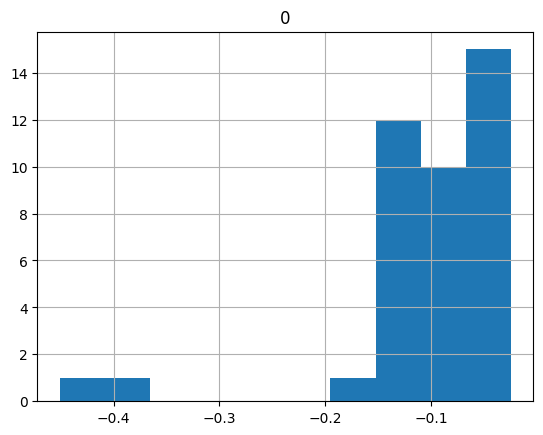

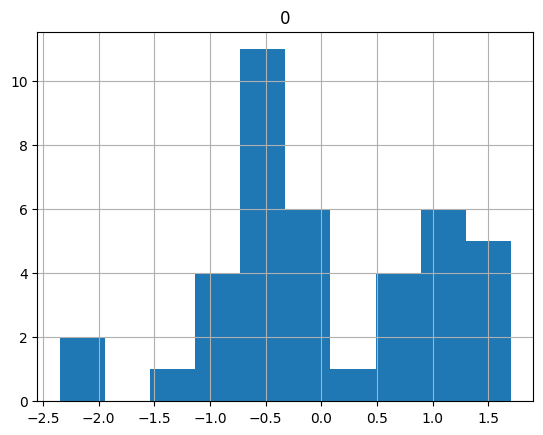

In [27]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Assuming f1_out is a NumPy array or a pandas Series
f1_out_transformed = PowerTransformer(method='yeo-johnson').fit_transform(f1_out.reshape(-1, 1))

# The transformed data is now stored in f1_out_transformed
f1_out, f1_out_transformed

original_out = pd.DataFrame(f1_out)
transformed_out = pd.DataFrame(f1_out_transformed)
original_out.hist(), transformed_out.hist()


# Standardization (Z-score Normalization)
f1_mean = np.mean(f1_out)
f1_std = np.std(f1_out)

f1_out_standardized = (f1_out - f1_mean) / f1_std  # Z-score transformation

print(f1_out_standardized)  # Standardized output



<Axes: >

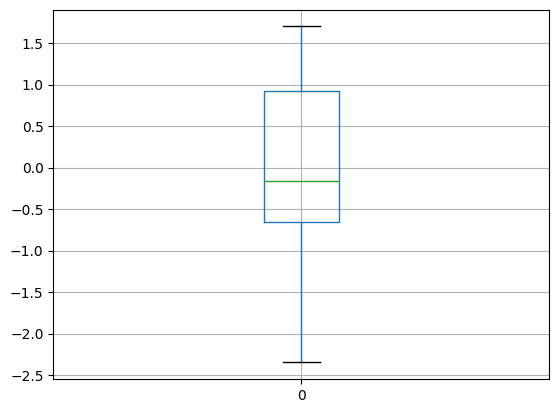

In [28]:
transformed_out.boxplot()

###### The above is giving me bad LML, I will try other transformation


In [29]:
# c = abs(f1_out.min()) + 1e-6  # Small buffer to avoid log(0)
# f1_out_transformed1 = np.log(np.abs(f1_out) + c)

# print(f1_out_transformed1)
# np.std(f1_out), np.std(f1_out_transformed1)
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# f1_out_transformed_scaled = scaler.fit_transform(f1_out_transformed1.reshape(-1, 1)).flatten()

# print(f1_out_transformed_scaled)
# np.std(f1_out_transformed_scaled)  # Should be ~1

# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [30]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)

f1_inp_normalized

array([[0.13084091, 0.28919403, 0.24873595],
       [0.20489672, 0.6463054 , 0.27243163],
       [0.51206658, 0.35413523, 0.17338725],
       [0.46766378, 0.60766113, 0.34017541],
       [0.09212509, 0.14166584, 0.45820559],
       [0.3133838 , 1.        , 0.26936229],
       [0.11018546, 0.40349748, 0.99088284],
       [0.62809498, 0.35251959, 0.9197721 ],
       [0.73448416, 0.21814167, 0.22629853],
       [0.12974122, 0.70931217, 0.14916788],
       [0.18227256, 0.23435666, 0.34355438],
       [0.64961306, 0.67951228, 0.24629404],
       [0.        , 0.15528012, 0.7706179 ],
       [0.58045962, 0.74274802, 0.06608684],
       [0.96432595, 0.90453453, 0.56682883],
       [0.12472942, 0.18561341, 0.65468996],
       [0.63385825, 0.38467819, 0.52674395],
       [0.06211109, 0.1695232 , 0.65025649],
       [0.32035092, 0.00590431, 0.06546605],
       [0.82069368, 0.40275815, 0.20713291],
       [0.79531275, 0.25130376, 0.24371314],
       [0.43562311, 0.03396845, 0.83858687],
       [0.

In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor



In [32]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


ModuleNotFoundError: No module named 'deap'

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object),
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
        [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object))

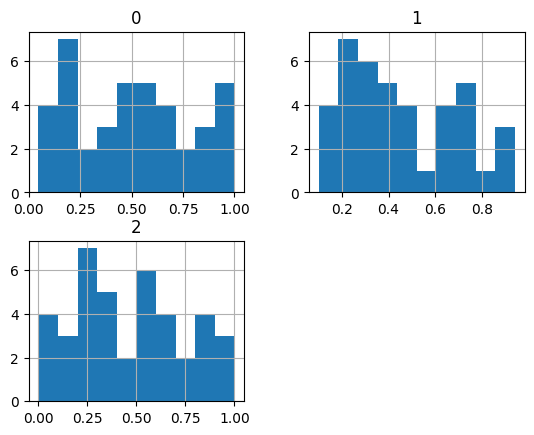

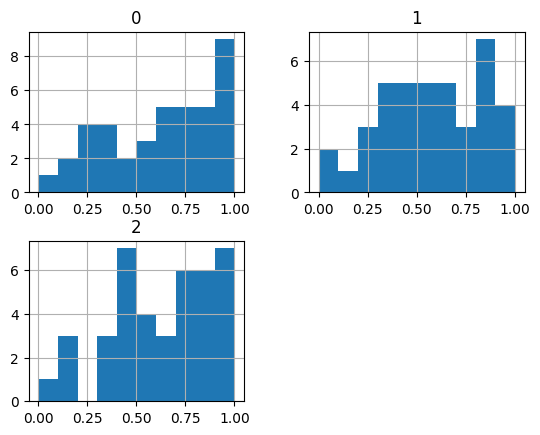

In [33]:

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel

# Kumaraswamy warping function
def kumaraswamy_warp(x, a, b):
    x = np.clip(x, 1e-10, 1 - 1e-10)  # Avoid numerical issues
    return 1 - (1 - x**a)**b

# Normalize input data
def normalize_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.663489, b=1.21400)
f1_inp, f1_inp_warped


np.var(f1_inp),skew(f1_inp), np.var(f1_inp_warped),skew(f1_inp_warped)
f1_inp, f1_inp_warped


pd_inp_transformed = pd.DataFrame(f1_inp_warped)

pd_inp.hist(), pd_inp_transformed.hist()

In [34]:
# SKEWNES IMPROVED/ POSITIVE RESULT


# ***************************** Gaussian Process****************************


# Testing Diffrent Kernels 

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import cross_val_score
from tqdm import tqdm  # simple loading bar

# --- Grid Search Space ---
length_scales = [0.001, 0.01, 0.03, 0.05,0.07, 0.09, 0.1,0.15,0.17,0.2,0.25, 0.3 ,0.5, 1.0, 2.0]
noise_levels = [1e-4, 1e-3, 1e-2, 0.05, 0.1]

results = []

# --- Grid Search ---
for ls in tqdm(length_scales, desc="Searching Length Scales"):
    for noise in noise_levels:
        # Define Kernel
        kernel = C(1.0) * Matern(length_scale=ls, nu=1.5) + WhiteKernel(noise_level=noise)
        
        # Gaussian Process
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, random_state=42)
        gp.fit(x_final, y_final)

        # Log Marginal Likelihood
        lml = gp.log_marginal_likelihood()

        # Cross-validation score (negative MSE)
        scores = cross_val_score(gp, x_final, y_final, scoring='neg_mean_squared_error', cv=5)
        mse = -scores.mean()

        # Save results
        results.append({'length_scale': ls, 'noise_level': noise, 'LML': lml, 'CV_MSE': mse})

# --- Display Results ---
print("\nResults (sorted by LML):")
results = sorted(results, key=lambda x: x['LML'], reverse=True)
for r in results:
    print(r)


In [65]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

best_kernel = C(1.0) * Matern(length_scale=0.03, nu=1.5) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=3, random_state=42)
gp.fit(f1_inp, f1_out)
print("LML:", gp.log_marginal_likelihood())


LML: 50.53830565813368


C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [2]:
x_final = f1_inp 
y_final = f1_out

In [3]:
import numpy as np

# Get indices of top 3 outputs (higher = better)
top_indices = np.argsort(y_final)[-4:][::-1]

# Get the top 3 output values
top_outputs = y_final[top_indices]

# Get corresponding inputs
top_inputs = x_final[top_indices]
top_inputs,top_outputs
# 0.586528-0.319323-0.433549 
# 0.578528  , 0.319323  , 0.443549 

(array([[0.576528  , 0.319323  , 0.453549  ],
        [0.576528  , 0.319323  , 0.493549  ],
        [0.56653   , 0.329309  , 0.523493  ],
        [0.57579775, 0.32285284, 0.53417744]]),
 array([-0.01316658, -0.02181244, -0.02492536, -0.02514614]))

C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [0.39210997 0.94135812 0.89387385]


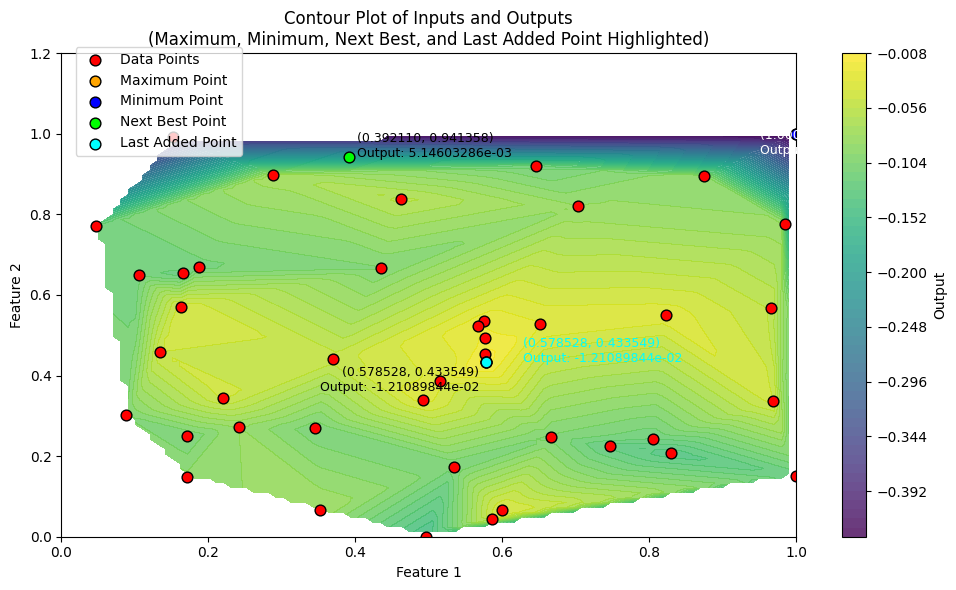

Maximum Value: -1.21089844e-02 at (x1=0.5785, x2=0.433549) at output, -0.012108984367773658
Minimum Value: -4.50707337e-01 at (x1=1.0000, x2=0.999999)
Last Added Point: -1.21089844e-02 at (x1=0.578528, x2=0.433549)
------------------------------------------------------------------------------------------------------------
Next Best Point (MACE): 5.14603286e-03 at (x1=0.392110, x2=0.941358, x3=0.893874 )


In [5]:

import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from scipy.interpolate import griddata
from pymoo.core.problem import Problem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic, WhiteKernel, RBF

class HEBOOptimizer:
    def __init__(self, bounds, initial_X=None, initial_y=None,
                 beta=2.5, xi=1.0, epsilon=0.1, random_state=None, noise_factor=0.01):

        self.bounds = np.array(bounds)
        self.dim = len(bounds)
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)
        
        # Initialize data storage
        self.X = initial_X 
        self.y = initial_y 
        noise_level = max(noise_factor * np.var(x_final), 1e-8)
        # Configure GP kernel
        self.kernel = C(1.0) * Matern(length_scale=0.03, nu=1.5) + WhiteKernel(noise_level=0.0001)
        
    def _fit_gp(self, kernel=None):
        if kernel is None:
            kernel = self.kernel  # n_restarts_optimizer=10,
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False,
            random_state=self.rng
        )
        gp.fit(self.X, self.y)
        return gp



    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                mu, sigma = self.gp.predict(X, return_std=True)
                
                # Correct way to access noise level
                noise_var = self.gp.kernel_.get_params().get('k2__noise_level', 1e-9)
                
                mu_adj = mu + self.xi * noise_var  # HEBO's stochastic mean
                
                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu_adj - self.best) / sigma
                
                ei = (mu_adj - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu_adj + self.beta * sigma
                
                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y) == 0:
            return self._random_sample()
        
        problem = MACEProblem(gp, self.bounds, np.max(self.y), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem, algorithm, ("n_gen", 100), verbose=False)
        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        # Fit GP with current data
        gp = self._fit_gp()
        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y = np.concatenate([self.y, np.atleast_1d(y_new)])

def get_bayesian_bounds(x_final):
    """
    Given a 2D array x_final (N rows, d features),
    returns a list of (min, max) tuples for each feature 
    to serve as bounds in Bayesian optimization.
    """
    min_vals = np.min(x_final, axis=0)
    max_vals = np.max(x_final, axis=0)
    return [(low, high) for low, high in zip(min_vals, max_vals)]
bounds = get_bayesian_bounds(x_final)

hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=x_final,
    initial_y=y_final,
    beta = 1,      # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    xi = 0.02, # Increases exploration in noisy areas, expanding search range# Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    epsilon = 0.01 # # Exploration probabiselflity: Higher ε increases random sampling
)

# 3. Get next candidate point
next_point = hebo.suggest_next_point().flatten()

# next z is predicited value at the inputs found from nextpoint, we use gausian
# process that we had trained above 
next_z = hebo._fit_gp().predict(next_point.reshape(1, -1))[0]
print(f"Next point to evaluate: {next_point}")



x = x_final[:, 0]
y = x_final[:, 2]
z = y_final.ravel()

# Define grid for contour plot
grid_x, grid_y = np.mgrid[0:1:100j, 0:1.2:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')  # Safer than 'cubic'

# Find min/max points
max_idx = np.argmax(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_idx = np.argmin(z)
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]
last_x, last_y, last_z = x[-1], y[-1], z[-1]

# Create figure
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=60, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
s = 60  # Point size

# Plot data points
plt.scatter(x, y, color='red', label="Data Points", edgecolor='black', s=s)
plt.scatter(max_x, max_y, color='orange', edgecolor='black', s=s, label="Maximum Point")
plt.text(
    max_x - 0.01,  # Move left
    max_y - 0.01,  # Move down
    f"({max_x:.6}, {max_y:.6f})\nOutput: {max_z:.8e}",
    color='black',
    fontsize=9,
    ha='right',  # Align text to the right of the new position
    va='top'  # Align text to the top of the new position
)

plt.scatter(min_x, min_y, color='blue', edgecolor='black', s=s, label="Minimum Point")
plt.text(min_x - 0.05, min_y - 0.05, f"({min_x:.4f}, {min_y:.4f})\nOutput: {min_z:.8e}", color='white', fontsize=9)

# Plot next best acquisition point
plt.scatter(next_point[0], next_point[1], color='lime', edgecolor='black', s=s, label="Next Best Point")
plt.text(
    next_point[0] + 0.01, next_point[1],
    f"({next_point[0]:.6f}, {next_point[1]:.6f})\nOutput: {next_z:.8e}",
    color='black',
    fontsize=9
)

# Plot last added point
plt.scatter(last_x, last_y, color='cyan', edgecolor='black', s=s, label="Last Added Point")
plt.text(
    last_x + 0.05, last_y,
    f"({last_x:.6f}, {last_y:.6f})\nOutput: {last_z:.8e}",
    color='cyan',
    fontsize=9
)

# Final plot settings
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Outputs\n(Maximum, Minimum, Next Best, and Last Added Point Highlighted)")
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.9))
plt.tight_layout()
plt.show()

# Print information about the points
print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.6f}) at output, {np.max(y_final)}")
print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.6f})")
print(f"Last Added Point: {last_z:.8e} at (x1={last_x:.6f}, x2={last_y:.6f})")
print("------------------------------------------------------------------------------------------------------------")
print(f"Next Best Point (MACE): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f}, x3={next_point[2]:.6f} )")

In [69]:

def kumaraswamy_inverse_warp(Y, a, b):
    # Ensure Y is a numpy array
    Y = np.asarray(Y)
    # Perform the transformation
    values = (1 - (1 - Y) ** (1/b)) ** (1/a)
    # Format each value as a string with six decimal places
    formatted = '-'.join(f"{v:.6f}" for v in values.tolist())
    # Print the requested format
    print(f"The requested format for submitting the queries is {formatted}")
    return formatted

next_point_original = kumaraswamy_inverse_warp(next_point, a=0.663489, b=1.441400)
next_point_original
next_point_original
#If there is an transformation 

The requested format for submitting the queries is 0.299201-0.112183-0.229165


'0.299201-0.112183-0.229165'

C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


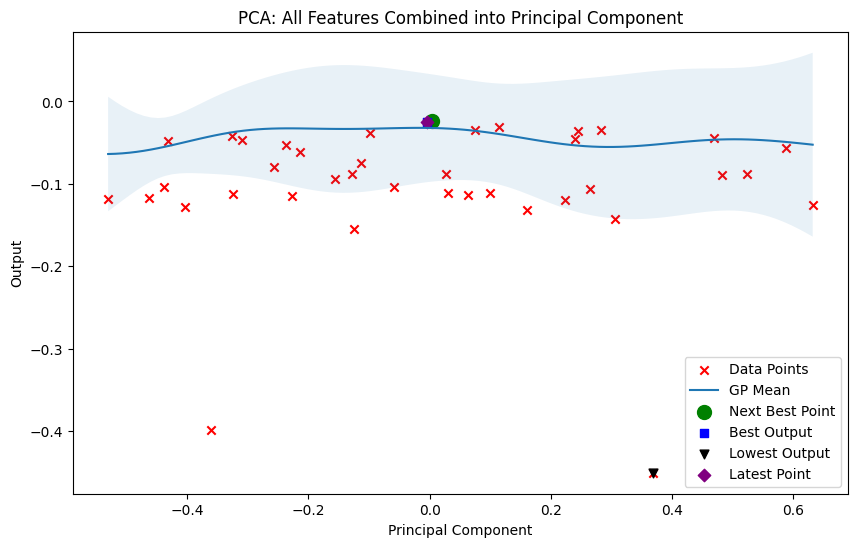

Predicted value at next best point: -0.023413221477016
Best output point: [0.56653, 0.329309, 0.523493], Value: -0.024925357620796
Lowest output point: [0.999999, 0.391643, 0.999999], Value: -0.450707336809612
Latest point: [0.56653, 0.329309, 0.523493], Value: -0.024925357620796
----------------------------------------------------------------------------------------------------------------
Next best point (2D): [0.57652997 0.3193176  0.49349368]


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
# Compute noise dynamically
# noise_level = max(0.01 * np.var(y_final), 1e-3)  # Ensures noise is never zero

# test_kernel = (
#             C(1.0, (1e-14, 1e3)) *  # ConstantKernel (scale)
#             (
#                 RBF(length_scale=[0.5, 0.2, 0.5],  # Large length scale for feature 2 (ignored)
#                     length_scale_bounds=[(0.05, 4.0), (0.05, 200.0), (0.05, 4.0)])
          
#             )
#             + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-6, 0.1))  # Noise
#         )

# # # Fit GP model
# hebo.kernel = test_kernel  # e.g., RBF(...) + WhiteKernel(...)
next_point = hebo.suggest_next_point()


# Reduce to 1D using PCA
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()


# Define grid along PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))



gp = hebo._fit_gp()
# Get predictions
mean_pred, std_pred = gp.predict(X_plot, return_std=True)




# Find the best, lowest, and latest points
best_idx = np.argmax(y_final)  # Highest output
low_idx = np.argmin(y_final)   # Lowest output
latest_idx = -1                # Last added point

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.1)

# Plot next best point
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=100, marker='o', label='Next Best Point')

# Highlight special points
plt.scatter(t_data[best_idx], y_final[best_idx], color='blue', s=40, marker='s', label='Best Output')   # Best
plt.scatter(t_data[low_idx], y_final[low_idx], color='black', s=40, marker='v', label='Lowest Output')   # Lowest
plt.scatter(t_data[latest_idx], y_final[latest_idx], color='purple', s=40, marker='D', label='Latest Point')  # Latest

plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()


print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.15f}")
print(f"Best output point: {x_final[best_idx].tolist()}, Value: {y_final[best_idx].item():.15f}")
print(f"Lowest output point: {x_final[low_idx].tolist()}, Value: {y_final[low_idx].item():.15f}")
print(f"Latest point: {x_final[latest_idx].tolist()}, Value: {y_final[latest_idx].item():.15f}")
print("----------------------------------------------------------------------------------------------------------------")
print("Next best point (2D):", next_point)

In [57]:
# Changed to the below for mor explotation 

C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\.conda\envs\blackbox_env\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


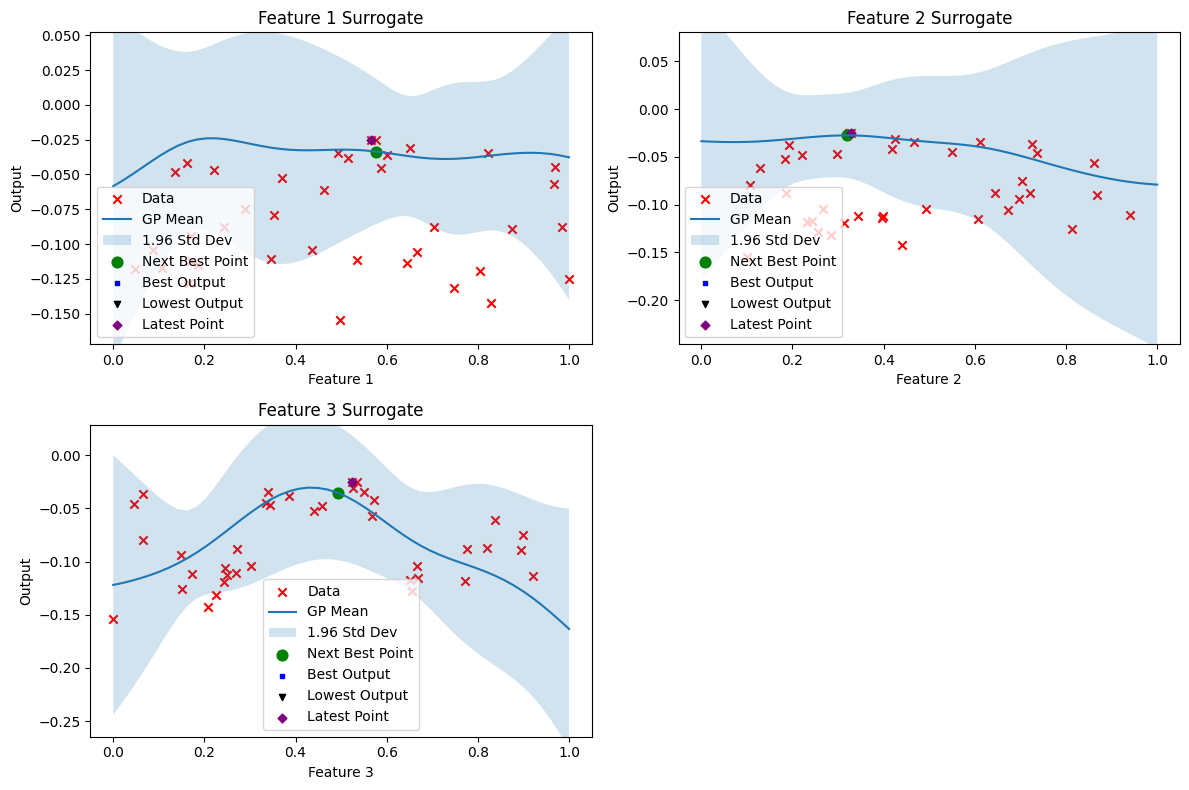

Best output point: [0.56653, 0.329309, 0.523493], Value: -0.024925357620796
Lowest output point: [0.999999, 0.391643, 0.999999], Value: -0.450707336809612
Latest point: [0.56653, 0.329309, 0.523493], Value: -0.024925357620796


In [71]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gp_slices_clamped(hebo, f1_inp, f1_out, beta=1.96, n_points=100, kernel=None):
    """
    Plots 1D slices of the Gaussian Process model learned by HEBO.
    Each plot represents how the function behaves for a single feature while 
    holding other features constant at their mean values.
    """
    
    # Fit the GP model from HEBO
    gp = hebo._fit_gp(kernel=kernel)

    # Get next best point from HEBO
    next_point = hebo.suggest_next_point().flatten()

    # Means of other features
    means_other_features = np.mean(f1_inp, axis=0)

    # Full-dimensional prediction of the next point
    next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)
    n_features = f1_inp.shape[1]

    # Find key points: Best, Lowest, and Latest
    best_idx = np.argmax(f1_out)   # Highest output
    low_idx = np.argmin(f1_out)    # Lowest output
    latest_idx = -1                # Last added point

    # Determine subplot grid
    n_cols = 2 if n_features > 1 else 1
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = np.array(axes).ravel()  # Flatten any structure into a 1D array


    for i in range(n_features):
        ax = axes[i]

        # Build 1D grid for feature i
        grid = np.linspace(0, 1, n_points)
        X_plot = np.tile(means_other_features, (n_points, 1))
        X_plot[:, i] = grid

        # Predict on the grid
        mean_pred, std_pred = gp.predict(X_plot, return_std=True)

        # Observed data for this feature
        y_data = f1_out
        x_feat = f1_inp[:, i]

        # Posterior confidence band
        y_pred_lower = mean_pred - beta * std_pred
        y_pred_upper = mean_pred + beta * std_pred

        # Next best point on this feature slice
        X_next = means_other_features.copy()
        X_next[i] = next_point[i]
        y_next_dim = gp.predict(X_next.reshape(1, -1))[0]

        # Collect values for robust percentile-based y-axis clamping
       # Ensure y_data is 1D before concatenation
        y_all = np.concatenate([y_data.ravel(), y_pred_lower, y_pred_upper, [y_next_dim]])

        y_low, y_high = np.percentile(y_all, [2, 95])  # Clamping y-limits

        # Plot observed data points
        ax.scatter(x_feat, y_data, color='red', marker='x', label='Data')

        # Plot posterior mean prediction
        ax.plot(grid, mean_pred, label='GP Mean')

        # Plot confidence band
        ax.fill_between(grid, y_pred_lower, y_pred_upper, alpha=0.2, label=f'{beta} Std Dev')

        # Mark next best point
        ax.scatter(next_point[i], y_next_dim, color='green', s=60, marker='o', label='Next Best Point')

        # Mark best, lowest, and latest points
        ax.scatter(f1_inp[best_idx, i], f1_out[best_idx], color='blue', s=10, marker='s', label='Best Output')
        ax.scatter(f1_inp[low_idx, i], f1_out[low_idx], color='black', s=20, marker='v', label='Lowest Output')
        ax.scatter(f1_inp[latest_idx, i], f1_out[latest_idx], color='purple', s=20, marker='D', label='Latest Point')

        ax.set_title(f'Feature {i+1} Surrogate')
        ax.set_xlabel(f'Feature {i+1}')
        ax.set_ylabel('Output')
        ax.legend()
        ax.set_ylim([y_low, y_high])  # Apply clamping

    # Hide any extra subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print next best point details
    print(f"Best output point: {f1_inp[best_idx].tolist()}, Value: {f1_out[best_idx].item():.15f}")
    print(f"Lowest output point: {f1_inp[low_idx].tolist()}, Value: {f1_out[low_idx].item():.15f}")
    print(f"Latest point: {f1_inp[latest_idx].tolist()}, Value: {f1_out[latest_idx].item():.15f}")


# ✅ **Now call the function with HEBO**
plot_gp_slices_clamped(hebo, x_final, y_final, beta=1.96, n_points=50)


In [ ]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface with fine resolution and smoother appearance
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none', rcount=100, ccount=100
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter points
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
#ax.scatter(max_x, max_y, max_z, color='orange', edgecolor='black', s=60, label="Maximum Point")
#ax.scatter(min_x, min_y, min_z, color='blue', edgecolor='black', s=60, label="Minimum Point")
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 3")
# ax.set_zlabel("Output")
ax.set_title("Acquisition Function Result: Next Predicted Query Point", loc="center")



# Custom viewing angle and legend
ax.view_init(elev=30, azim=-60)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f"    Next Best Point: at (x1={next_point[0]:.6f}, x3={next_point[2]:.6f})")

